In [1]:
import keras
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential, Model
from scipy.stats import pearsonr
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.backend.tensorflow_backend import set_session
from keras import backend as K
from keras.backend import slice
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import time
import pickle
import os

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Functions

In [10]:
def load_data(station): ## Station in String
    flow = np.load('../usgsflow_'+station+'.npy')
    precip = np.load('../NLDAS_precip_'+station+'.npy')
    srad = np.load('../NLDAS_srad_'+station+'.npy')
    tmax = np.load('../NLDAS_tmax_'+station+'.npy')
    y = np.array(flow).reshape(-1, 1)
    indx = np.where(y>=0)[0]
    # print(precip.shape)
    date = np.load('../usgsdate_'+station+'.npy', allow_pickle=True)
    x = np.concatenate((precip, srad, tmax), axis=1)
    return x, y
def nse(y_pred, y_true):
    nse = 1-np.sum((y_pred-y_true)**2)/np.sum((y_true-np.mean(y_true))**2)
    return nse
def dataset_ld(x,y,W,L):
    obs = x.shape[0]
    features = x.shape[1]
    a = np.zeros([obs-W-L+1, W, features])
    b = np.zeros([obs-W-L+1, 1])
    for i in range(obs-W-L+1):
        a[i,:,:] = x[i:i+W,:]
        b[i,:] = y[i+W+L-1,0]    
    return a, b
def train_test_pre(x, y):
    xtrain = x[:10000]; xtest = x[10000:]
    ytrain = y[:10000]; ytest = y[10000:]
    xscale = StandardScaler().fit(xtrain)
    yscale = StandardScaler().fit(ytrain)
    Xtrain = xscale.transform(xtrain); Xtest = xscale.transform(xtest)
    Ytrain = yscale.transform(ytrain); Ytest = yscale.transform(ytest)
    return Xtrain, Xtest, Ytrain, Ytest, xscale, yscale
def custom_loss(y_true, y_pred):
    s1 = K.sum((y_pred-y_true)**2)/K.sum((y_true-K.mean(y_true))**2)
    return s1

In [11]:
def build_model(W,L):
    x_in = keras.layers.Input(shape=(W,3)) # Batch, Length, Dimension
    ## Block 1
    x_tp = keras.layers.Conv1D(kernel_size=7, filters=40, dilation_rate=1, padding='causal')(x_in)
    # x_tp = keras.layers.BatchNormalization()(x_tp)
    x_tp = keras.layers.Activation('relu')(x_tp)
    x_tp = keras.layers.Dropout(0.6)(x_tp)
    x_tp = keras.layers.Conv1D(kernel_size=7, filters=40, dilation_rate=1, padding='causal')(x_tp)
    # x_tp = keras.layers.BatchNormalization()(x_tp)
    x_tp = keras.layers.Activation('relu')(x_tp)
    x_tp = keras.layers.Dropout(0.6)(x_tp)
    ## add res for block 1
    x_res = keras.layers.Conv1D(kernel_size=1, filters=40, dilation_rate=1, padding='causal')(x_in)
    x_tp = keras.layers.Add()([x_tp, x_res])
    x_tp = keras.layers.Activation('relu')(x_tp)
    ## Block 2
    x_block1 = x_tp
    x_tp = keras.layers.Conv1D(kernel_size=7, filters=20, dilation_rate=6, padding='causal')(x_tp)
    # x_tp = keras.layers.BatchNormalization()(x_tp)
    x_tp = keras.layers.Activation('relu')(x_tp)
    x_tp = keras.layers.Dropout(0.6)(x_tp)
    x_tp = keras.layers.Conv1D(kernel_size=7, filters=20, dilation_rate=6, padding='causal')(x_tp)
    # x_tp = keras.layers.BatchNormalization()(x_tp)
    x_tp = keras.layers.Activation('relu')(x_tp)
    x_tp = keras.layers.Dropout(0.6)(x_tp)
    ## add res for block 2
    x_res = keras.layers.Conv1D(kernel_size=1, filters=20, dilation_rate=1, padding='causal')(x_block1)
    x_tp = keras.layers.Add()([x_tp, x_res])
    # x_tp = keras.layers.Add()([x_tp, x_block1])
    x_tp = keras.layers.Activation('relu')(x_tp)    
    ## Block 3
    x_block2 = x_tp
    x_tp = keras.layers.Conv1D(kernel_size=7, filters=20, dilation_rate=12, padding='causal')(x_tp)
    # x_tp = keras.layers.BatchNormalization()(x_tp)
    x_tp = keras.layers.Activation('relu')(x_tp)
    x_tp = keras.layers.Dropout(0.6)(x_tp)
    x_tp = keras.layers.Conv1D(kernel_size=7, filters=20, dilation_rate=12, padding='causal')(x_tp)
    # x_tp = keras.layers.BatchNormalization()(x_tp)
    x_tp = keras.layers.Activation('relu')(x_tp)
    x_tp = keras.layers.Dropout(0.6)(x_tp)
    ## add res for block 3
    # x_res = keras.layers.Conv1D(kernel_size=1, filters=20, dilation_rate=1, padding='causal')(x_block2)
    # x_tp = keras.layers.Add()([x_tp, x_res])
    x_tp = keras.layers.Add()([x_tp, x_block2])
    x_tp = keras.layers.Activation('relu')(x_tp)
    ## SLICE
    x_tp = keras.layers.Lambda(lambda x:slice(x,(0,80,0),(-1,-1,-1)))(x_tp) # batch, length, channels 
    x_tp = keras.layers.Flatten()(x_tp)
    x_tp = keras.layers.Dropout(0.5)(x_tp)
    x_tp = keras.layers.Dense(100, activation='relu')(x_tp)
    x_tp = keras.layers.Dropout(0.5)(x_tp)
    x_out = keras.layers.Dense(1)(x_tp)
    model = Model(inputs=x_in, outputs=x_out)
    return model

## Constant

In [12]:
lr = 0.0005; W=365; L=0;
f = open('../../StationArea.pkl','rb')
areas = pickle.load(f); f.close()

CNN/10258500_DCNN.h5


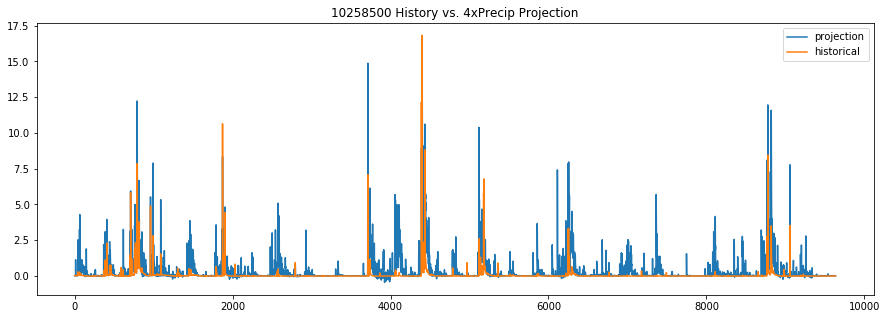

CNN/10259000_DCNN.h5


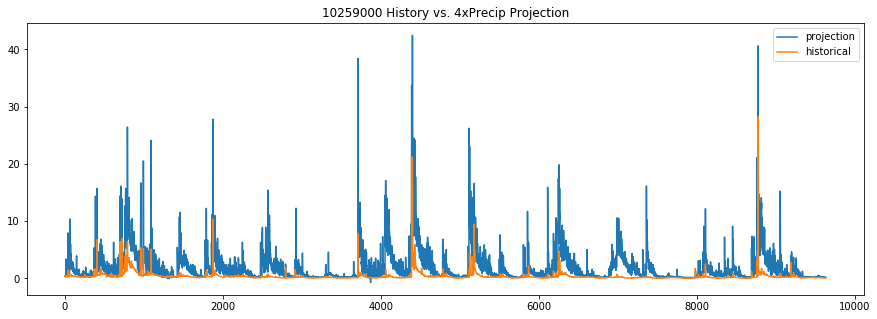

CNN/10259200_DCNN.h5


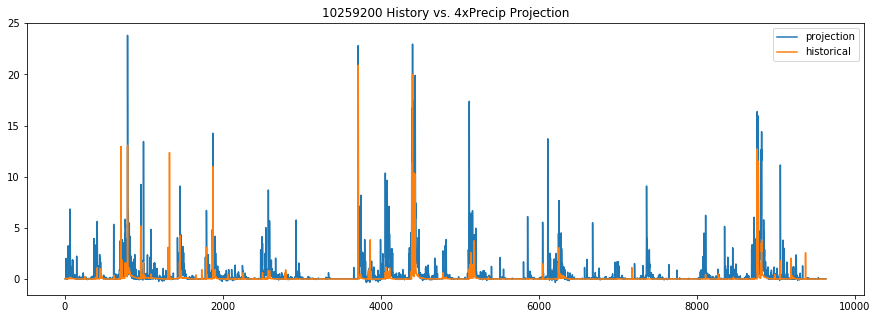

CNN/10343500_DCNN.h5


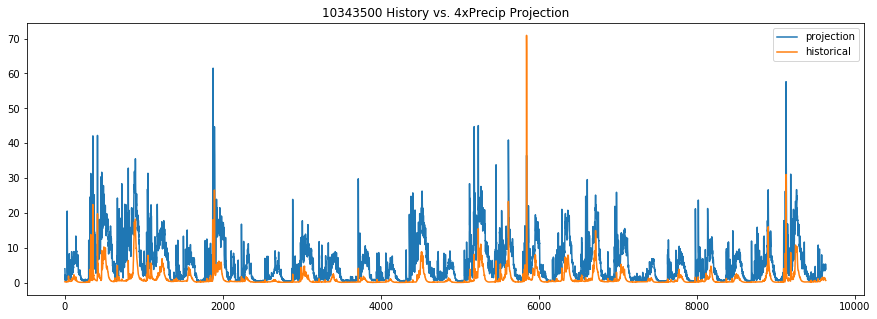

CNN/11141280_DCNN.h5


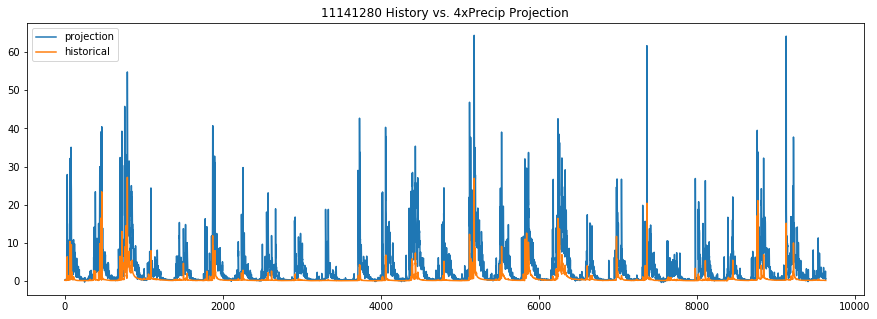

CNN/11143000_DCNN.h5


KeyboardInterrupt: 

In [13]:
stations = np.load('../first-stations.npy')
for station in stations:
    model_name = 'CNN/'+str(station)+'_DCNN.h5'
    print(model_name)
    model=build_model(W, L)
    adam = keras.optimizers.Adam(lr=lr)
    model.compile(loss=custom_loss, optimizer=adam)
    model.load_weights(model_name)
    ## load data.
    x, y = load_data(str(station))
    area = areas[str(station)]
    ## Transform to Runoff
    y = y*86400*1000/(area*1000*1000)
    Xtrain, Xtest, Ytrain, Ytest, xscale, yscale = train_test_pre(x, y)
    X_train, Y_train = dataset_ld(Xtrain, Ytrain, W, L)
    X_test, Y_test = dataset_ld(Xtest, Ytest, W, L)
    y_true = yscale.inverse_transform((Y_train).reshape(-1, 1))
    ## Projection
    xtrain = x[:10000]; ytrain = y[:10000]
    xproj = xtrain.copy()
    xproj[:,0] = xproj[:,0]*4.00
    Xproj = xscale.transform(xproj)
    X_proj, Y_train = dataset_ld(Xproj, Ytrain, W, L)
    Y_proj = model.predict(X_proj)
    y_proj = yscale.inverse_transform((Y_proj).reshape(-1, 1))
    ## plot
    fig = plt.figure(figsize=(15,5))
    plt.plot(y_proj, label='projection')
    plt.plot(y_true, label='historical')
    plt.legend()
    plt.title(str(station)+' History vs. 4xPrecip Projection')
    plt.show()

## plot

In [14]:
SMALL_SIZE=8; MEDIUM_SIZE=14; BIGGER_SIZE=18
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

CNN/11528700_DCNN.h5


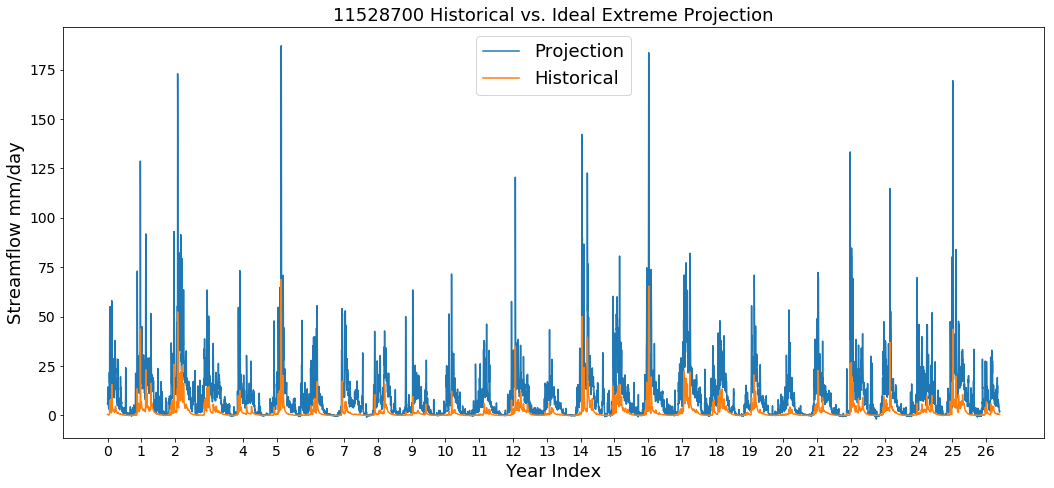

In [18]:
station = 11528700
model_name = 'CNN/'+str(station)+'_DCNN.h5'
print(model_name)
model=build_model(W, L)
adam = keras.optimizers.Adam(lr=lr)
model.compile(loss=custom_loss, optimizer=adam)
model.load_weights(model_name)
## load data.
x, y = load_data(str(station))
area = areas[str(station)]
## Transform to Runoff
y = y*86400*1000/(area*1000*1000)
Xtrain, Xtest, Ytrain, Ytest, xscale, yscale = train_test_pre(x, y)
X_train, Y_train = dataset_ld(Xtrain, Ytrain, W, L)
X_test, Y_test = dataset_ld(Xtest, Ytest, W, L)
y_true = yscale.inverse_transform((Y_train).reshape(-1, 1))
## Projection
xtrain = x[:10000]; ytrain = y[:10000]
xproj = xtrain.copy()
xproj[:,0] = xproj[:,0]*4.00
xproj[:,2] = xproj[:,2]+5.00
Xproj = xscale.transform(xproj)
X_proj, Y_train = dataset_ld(Xproj, Ytrain, W, L)
Y_proj = model.predict(X_proj)
y_proj = yscale.inverse_transform((Y_proj).reshape(-1, 1))
## plot
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(y_proj, label='Projection')
plt.plot(y_true, label='Historical')
plt.legend()
plt.title(str(station)+' Historical vs. Ideal Extreme Projection')
plt.ylabel('Streamflow mm/day')
plt.xlabel('Year Index')
fig.tight_layout()
year_loc = [0+i*365 for i in range(27)]
year = np.array(range(27))
ax.set_xticklabels(year)
ax.set_xticks(year_loc)
plt.savefig('11528700_ideal_test.eps')
plt.savefig('11528700_ideal_test.jpg')
plt.show()

In [19]:
print(y_proj.shape)
print(9636/365)

(9636, 1)
26.4


0.7454661990962304
[[4.00149695]]
0.0


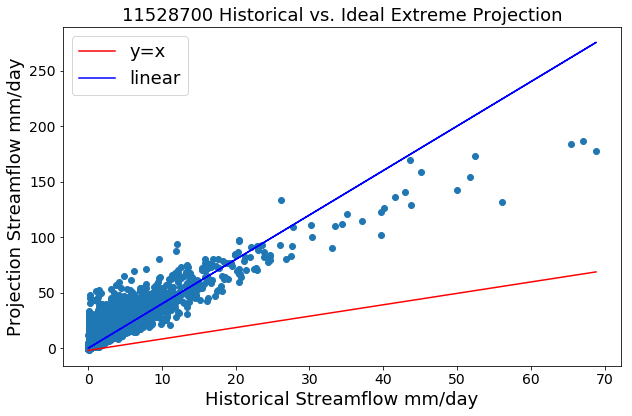

In [21]:
fig, ax = plt.subplots(figsize=(9,6))
plt.scatter(y_true, y_proj)
# plt.legend()
plt.title(str(station)+' Historical vs. Ideal Extreme Projection')
plt.ylabel('Projection Streamflow mm/day')
plt.xlabel('Historical Streamflow mm/day')
xmin = np.min(y_true)
xmax = np.max(y_true)
ymin = np.min(y_proj)
ymax = np.max(y_proj)
plt.plot([xmin, xmax], [ymin, xmax], c='r', label='y=x')

from sklearn.linear_model import LinearRegression
linear_model = LinearRegression(fit_intercept=False).fit(y_true, y_proj)
print(linear_model.score(y_true, y_proj))
k = linear_model.coef_
b = linear_model.intercept_
plt.plot(y_true, k*y_true+b, label='linear', c='b')
print(k)
print(b)
plt.legend()
fig.tight_layout()
plt.savefig('ideal_scatter.eps')

## Water Budget